# Violence classififcation_turkish_protest

In [1]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Data/GT_Data_extra_aggregated.csv')

In [3]:
df_violence = df[['text','violence','protest']]

In [4]:
d = df[df_violence['violence']==1]
len(d)

126

In [81]:
def k_fold_cross_validation(pipeline, df,label, n_folds):
    k_fold = KFold(n=len(df), n_folds=n_folds)
    F1_scores = []
    P_scores = []
    R_scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    for train_indices, test_indices in k_fold:
        train_text = df.iloc[train_indices]['text'].values
        train_y = df.iloc[train_indices][label].values

        test_text = df.iloc[test_indices]['text'].values
        test_y = df.iloc[test_indices][label].values

        pipeline.fit(train_text, train_y)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        F1_score = f1_score(test_y, predictions, pos_label=1)
        P_score = precision_score(test_y, predictions, pos_label=1)
        R_score = recall_score(test_y, predictions, pos_label=1)
        F1_scores.append(F1_score)
        P_scores.append(P_score)
        R_scores.append(R_score)

    print('Total emails classified:', len(df))
    print('F1 Score:', sum(F1_scores)/len(F1_scores))
    print('P Score:', sum(P_scores)/len(P_scores))
    print('R Score:', sum(R_scores)/len(R_scores))
    print('Confusion matrix:')
    print(confusion)

In [108]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [140]:
pipeline_violence_NB = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', min_df=10)),
    ('classifier',  MultinomialNB()) ])

k_fold_cross_validation(pipeline_violence_NB, df_violence,'violence', 6)

Total emails classified: 1000
F1 Score: 0.423642986199
P Score: 0.603081232493
R Score: 0.332295085786
Confusion matrix:
[[846  28]
 [ 83  43]]


In [141]:
pipeline_violence_BNB = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10)),
    ('classifier',  BernoulliNB(binarize=0.0)) ])

k_fold_cross_validation(pipeline_violence_BNB, df_violence, 'violence', 10)

Total emails classified: 1000
F1 Score: 0.40594047619
P Score: 0.444478854479
R Score: 0.41925070028
Confusion matrix:
[[812  62]
 [ 71  55]]


In [142]:
pipeline_violence_SGD = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10)),
    ('tfidf_transformer',  TfidfTransformer()),
    ('classifier',  SGDClassifier(random_state=42)) ])

k_fold_cross_validation(pipeline_violence_SGD, df_violence, 'violence',10)

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total emails classified: 1000
F1 Score: 0.248054989673
P Score: 0.365860528361
R Score: 0.204838935574
Confusion matrix:
[[833  41]
 [100  26]]


In [202]:
pipeline_violence_Svc = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english',  min_df=15)),
    ('tfidf_transformer',  TfidfTransformer()),
    ('classifier',  SVC(kernel='linear', gamma=2)) ])

k_fold_cross_validation(pipeline_violence_Svc, df_violence, 'violence',10)

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Total emails classified: 1000
F1 Score: 0.196154952599
P Score: 0.380555555556
R Score: 0.141071428571
Confusion matrix:
[[850  24]
 [107  19]]


In [146]:
#divide dataset to train test dataset
X_train, X_test, y_train, y_test = train_test_split(df_violence['text'], 
                                                    df_violence['violence'], 
                                                    test_size=0.33, 
                                                    random_state=42)

In [147]:
def plot_precision_recall(precision, recalls):
    plt.plot(recalls, precision, "b--", label="")
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="upper left")ngram_range=(1, 2),stop_words='english', min_df=10
    plt.ylim([0,1])

In [148]:
#predicted scores
scores = cross_val_score(pipeline_violence_Svc, X_train, y_train, cv =15)
print(scores.mean())
print(scores.std())

0.881932503328
0.039244576648


In [149]:
scores = cross_val_score(pipeline_violence_SGD, X_train, y_train, cv =10)
print(scores.mean())
print(scores.std())

0.873141644718
0.0372389030289


In [150]:
#decision scores to find the threshold between recall and precisions
y_scores = cross_val_predict(pipeline_violence_Svc, X_train, y_train, cv =10,method="decision_function")

In [181]:
y_scores2 = pipeline_violence_Svc.fit(X_train, y_train).decision_function(X_test)

In [221]:
roc_auc = roc_auc_score(y_test, y_scores2)
print(roc_auc)

0.80645871883


In [222]:
print(len(y_scores))
print(len(y_test))

670
330


In [223]:
#work around bug in 0.19
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [224]:
roc_auc = roc_auc_score(y_test, y_scores)
print(roc_auc)

ValueError: Found input variables with inconsistent numbers of samples: [330, 670]

In [152]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


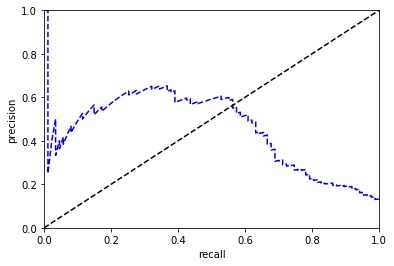

In [153]:
plot_precision_recall(precisions, recalls)
plt.show()

In [154]:
fpr, tpr , th = roc_curve(y_train, y_scores)

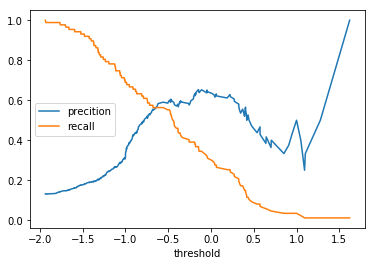

In [155]:
plt.plot(thresholds, precisions[:-1], '-', label='precition')
plt.plot(thresholds, recalls[:-1], '-', label='recall')
plt.xlabel("threshold")
plt.legend()
plt.show()

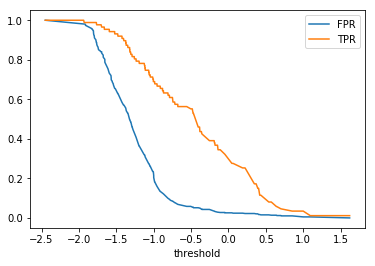

In [156]:
plt.plot(th, fpr, '-', label='FPR')
plt.plot(th, tpr, '-', label='TPR')
plt.xlabel("threshold")
plt.legend()
plt.show()

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


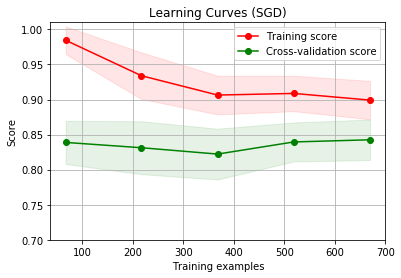

In [175]:
title = "Learning Curves (SGD)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_violence['text'].values)
estimator =  SGDClassifier(random_state=42)
plt = plot_learning_curve(estimator, title, X_train_counts, df_violence['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


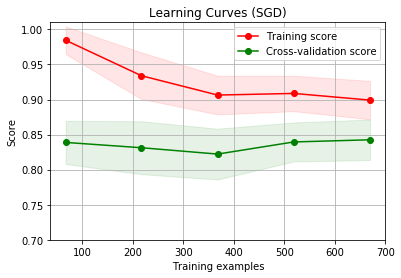

In [174]:
title = "Learning Curves (SGD)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_violence['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator =  SGDClassifier(random_state=42)
plt = plot_learning_curve(estimator, title, X_train_counts, df_violence['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=100)
plt.show()

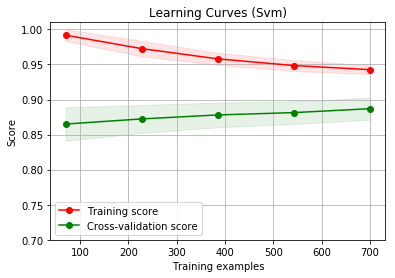

In [173]:
title = "Learning Curves (Svm)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 30% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.30, random_state=50)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_violence['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator = SVC(kernel='linear', gamma=2)
plt = plot_learning_curve(estimator, title, X_train_counts, df_violence['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=30)
plt.show()

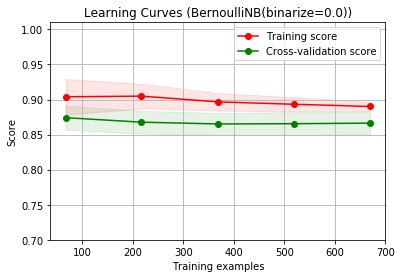

In [172]:
title = "Learning Curves (BernoulliNB(binarize=0.0))"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_violence['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator = BernoulliNB(binarize=0.0)
plt = plot_learning_curve(estimator, title, X_train_counts, df_violence['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=30)
plt.show()

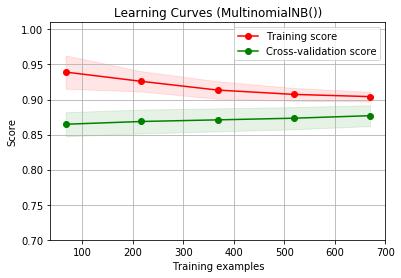

In [170]:
title = "Learning Curves (MultinomialNB())"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_violence['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator =  MultinomialNB()
plt = plot_learning_curve(estimator, title, X_train_counts, df_violence['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=200)
plt.show()

In [177]:
count_vect = CountVectorizer(stop_words='english', min_df=15, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_violence['text'].values).toarray()
vocab = np.array(count_vect.get_feature_names())
len(vocab)

66

In [178]:
print(count_vect.get_feature_names())

['0000', '2013', 'amp', 'ankara', 'attack', 'cnn', 'come', 'country', 'crowd', 'democracy', 'direnankara', 'direngezi', 'direngezipark', 'direngeziparki', 'erdogan', 'gas', 'gezi', 'gezipark', 'going', 'government', 'http', 'https', 'istanbul', 'jun', 'just', 'know', 'let', 'like', 'live', 'media', 'minister', 'need', 'new', 'news', 'occupygezi', 'occupyturkey', 'park', 'people', 'photo', 'pm', 'police', 'prime', 'protest', 'protesters', 'protestors', 'protests', 'right', 'rt', 'say', 'says', 'square', 'stop', 'support', 'taksim', 'tear', 'time', 'today', 'turkey', 'turkish', 'twitter', 'video', 'violence', 'watch', 'water', 'world', 'youranonnews']


In [215]:
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(df_violence['text'].values), 2200))

# Add noisy data to the informative features for make the task harder
X = np.c_[df_violence['text'].values, E]

#svm = SVC(kernel='linear')
cv = StratifiedKFold(2)

score, permutation_scores, pvalue = permutation_test_score(
    pipeline_violence_Svc, df_violence['text'].values, df_violence['violence'].values, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.835594420835 (pvalue : 0.00990099009901)


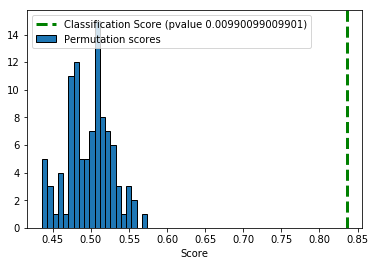

In [216]:
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
# plt.vlines(score, ylim[0], ylim[1], linestyle=from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score'--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
# plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)


plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [217]:
permutation_scores

array([ 0.53299916,  0.4443264 ,  0.50909883,  0.48179325,  0.5085994 ,
        0.53916494,  0.47968654,  0.47092369,  0.48416331,  0.47849697,
        0.52113981,  0.49288983,  0.44826741,  0.48372743,  0.51243144,
        0.43599942,  0.47676256,  0.50307835,  0.51102394,  0.50090807,
        0.44328212,  0.47247648,  0.46324144,  0.48413606,  0.50593876,
        0.49713959,  0.51598198,  0.48427227,  0.51993208,  0.47399295,
        0.5308198 ,  0.5259798 ,  0.44276452,  0.53083796,  0.45075551,
        0.55927863,  0.43620827,  0.48467182,  0.46288729,  0.47436526,
        0.48715993,  0.52255639,  0.50770041,  0.479514  ,  0.49523265,
        0.53146453,  0.47584541,  0.54728306,  0.51029748,  0.49650394,
        0.57389851,  0.47423813,  0.50530311,  0.51229523,  0.47064219,
        0.50761868,  0.5532309 ,  0.46858995,  0.49571392,  0.52927609,
        0.51899677,  0.48396353,  0.51267662,  0.50647452,  0.51499219,
        0.49015655,  0.50343249,  0.51099669,  0.50578439,  0.47